# Detection of Bot / Real Profiles

## Support Vector Machine and Random Forest

In [1]:
!pip install gender_guesser

import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import gender_guesser.detector as gender

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [2]:
def read_datasets():
    
    """ Reads users profile from csv files """
    real_users = pd.read_csv("data/users.csv")
    bot_users = pd.read_csv("data/bot.csv")
    
    x = pd.concat([real_users,bot_users])    
    y = len(real_users)*[0] + len(bot_users)*[1]
    
    return x,y

In [3]:
def predict_sex(name):
    d = gender.Detector(case_sensitive=False)
    first_name= str(name).split(' ')[0]
    sex = d.get_gender(u"{}".format(first_name))
    
    sex_code_dict = {'female': -2, 'mostly_female': -1,'unknown':0, 'andy': 0, 'mostly_male':1, 'male': 2}
    code = sex_code_dict[sex]
    
    return code

In [4]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    
    lang_dict = { name : i for i, name in lang_list }             
    print(lang_dict)
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code'] = predict_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x = x.loc[:,feature_columns_to_use]
    
    return x

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [6]:
def plot_confusion_matrix(cm, title='CONFUSION MATRIX', cmap=plt.cm.Reds):
    target_names=['Bot','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def train(X_train,y_train,X_test, nSplits, CV):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    
    cvk = StratifiedKFold(n_splits= nSplits)
    
    classifier = SVC()
    
    clf = GridSearchCV(classifier, param_grid=param, cv=cvk)
    clf.fit(X_train,y_train)
    
    print("The best classifier is: ", clf.best_estimator_)
    clf.best_estimator_.fit(X_train, y_train)
    
    print()
    
    # Estimate score
    scores = cross_validate(clf.best_estimator_, X_train,y_train, cv=CV)
    
    for k in [*scores]:
        print(k + ": ", scores[k])
    
    print()
    
    print("Mean Training Score: {}".format(scores['fit_time'].mean()))
    print("Mean Test Score: {}".format(scores['test_score'].mean()))
    
    title = 'Learning Curves (SVM, rbf kernel, gamma={})'.format(clf.best_estimator_.gamma)
    
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=CV)
    plt.show()
    
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    
    return y_test,y_pred

In [8]:
x,y = read_datasets()
print("dataset read complete")

dataset read complete


In [9]:
x = extract_features(x)
print(x.columns)

{'de': 0, 'en': 1, 'es': 2, 'fr': 3, 'gl': 4, 'it': 5, 'nl': 6, 'tr': 7}
Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')


In [10]:
x.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,sex_code,lang_code
0,20370,5470,2385,145,52,0,5
1,3131,506,381,9,40,0,1
2,4024,264,87,323,16,0,1
3,40586,640,622,1118,32,0,1
4,2016,62,64,13,0,0,5


In [11]:
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
print(y[::-1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [13]:
# splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

The best classifier is:  SVC(C=316.22776601683796, gamma=1.0)

fit_time:  [0.0179522  0.0169549  0.01396251 0.02094412 0.0209434  0.01595736
 0.01894927]
score_time:  [0.00398898 0.00398946 0.00299191 0.00299168 0.0039897  0.00299191
 0.00299191]
test_score:  [0.99689441 0.99689441 0.99378882 0.99689441 1.         0.99689441
 0.99689441]

Mean Training Score: 0.01795196533203125
Mean Test Score: 0.9968944099378882


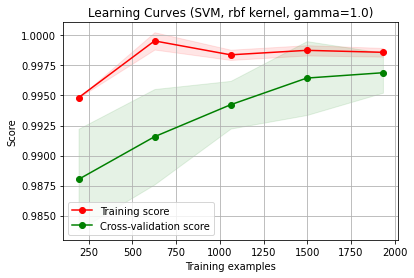

In [14]:
y_test,y_pred = train(X_train,y_train,X_test,5, 7)

Confusion matrix, without normalization
[[293   4]
 [  0 267]]


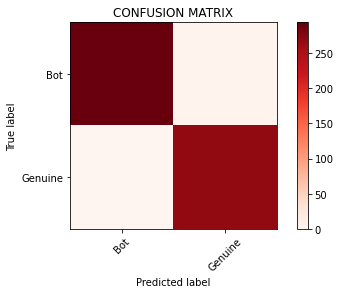

In [15]:
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(confusionMatrix)
plot_confusion_matrix(confusionMatrix)

In [16]:
print(classification_report(y_test, y_pred, target_names=['Bot','Genuine']))

              precision    recall  f1-score   support

         Bot       1.00      0.99      0.99       297
     Genuine       0.99      1.00      0.99       267

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



In [17]:
# RANDOM FOREST
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_classifier.fit(X_train, y_train)
train_predictions = rf_classifier.predict(X_train)
prediction = rf_classifier.predict(X_test)
print(X_test[:5])
print(prediction)

     statuses_count  followers_count  friends_count  favourites_count  \
512            9950              658            701                18   
630            6991             1001            614              2401   
189            1809              102            392                18   
343             770               42            149                28   
793              20               18            317                 0   

     listed_count  sex_code  lang_code  
512            11         0          5  
630             6         0          5  
189             1         0          5  
343             0         0          5  
793             0         0          1  
[0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0
 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1
 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1
 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 

In [18]:
err_training = mean_absolute_error(train_predictions, y_train)
err_test = mean_absolute_error(prediction, y_test)

print("Train Accuracy is : {}".format(100 - (100*err_training)))
print("Test Accuracy is : {}".format(100 - (100*err_test)))

Train Accuracy is : 99.33451641526176
Test Accuracy is : 99.11347517730496


In [19]:
prediction = rf_classifier.predict([[9950,658,701,18,11,0,5]])
print(X_test.head())
print(prediction)

     statuses_count  followers_count  friends_count  favourites_count  \
512            9950              658            701                18   
630            6991             1001            614              2401   
189            1809              102            392                18   
343             770               42            149                28   
793              20               18            317                 0   

     listed_count  sex_code  lang_code  
512            11         0          5  
630             6         0          5  
189             1         0          5  
343             0         0          5  
793             0         0          1  
[0]


In [20]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

False Positive rate:  [0.         0.01346801 1.        ]
True Positive rate:  [0. 1. 1.]


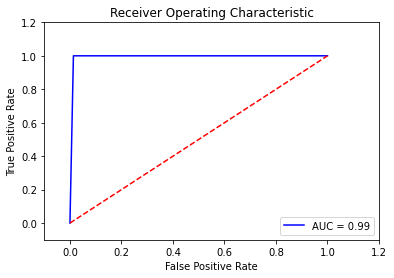

In [21]:
from sklearn.metrics import roc_curve, auc
plot_roc_curve(y_test, y_pred)

In [22]:
import pickle
pickle.dump(rf_classifier, open('rf_classifier.pkl', 'wb'))

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier()  
knn .fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9911347517730497
[[293   4]
 [  1 266]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       297
           1       0.99      1.00      0.99       267

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



In [26]:
dt = DecisionTreeClassifier()  
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9946808510638298
[[297   0]
 [  3 264]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       297
           1       1.00      0.99      0.99       267

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564

